In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
from sklearn.model_selection import ShuffleSplit

n_subsets = 1000
n_samples = 100

subsets = []

rs = ShuffleSplit(n_splits=n_subsets, test_size = len(X_train) - n_samples , random_state= 42)
for subset_train_idx , subset_test_idx in rs.split(X_train):
     X_sub_train = X_train[subset_train_idx]
     y_sub_train = y_train[subset_train_idx]
     subsets.append((X_sub_train,y_sub_train))

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [6]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)

In [7]:
from sklearn.base import clone
from sklearn.metrics import accuracy_score
import numpy as np


forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_subsets)]

accuracy_scores = []

for tree, (X_sub_train, y_sub_train) in zip(forest, subsets):
    tree.fit(X_sub_train, y_sub_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.805471

In [8]:
Y_pred = np.empty([n_subsets, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [9]:
from scipy.stats import mode

# y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)
y_pred_majority_votes, n_votes = mode(Y_pred)

In [10]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagging_clf = BaggingClassifier(
    DecisionTreeClassifier(),n_estimators=500,
    max_samples=100,bootstrap=True,n_jobs=-1)
bagging_clf.fit(X_train,y_train)
y_pred = bagging_clf.predict(X_test)




In [12]:
accuracy_score(y_test, y_pred)

0.871

### 7.3 랜덤패치와 랜덤 서브스페이스

특성샘플링도 지원함
- 훈련과 특성 모두 샘플링 - 랜덤패치방식 (bootstrap = False, max_sample= 1.0)
- 훈련샘플 not 샘플링(모두 사용) , 특성은 샘플링 - 랜덤서브스페이스 (bootstrap = True, max_sample 은 1.0 보다 작게 설정)

### 7.4 랜덤포레스트

In [13]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train,y_train)
y_pred_rf = rnd_clf.predict(X_test)

결정트리의 배깅

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)

In [15]:
np.sum(y_pred_bag == y_pred_rf) / len(y_pred_bag)

0.9965

#### 7.42 특성중요도

불순도를 얼마나 감소시키는지 확인하여 특성의 중요도 측정

In [16]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(iris['data'],iris['target'])
for name,score in zip(iris['feature_names'],rnd_clf.feature_importances_):
    print(name,score)

sepal length (cm) 0.10048948506290913
sepal width (cm) 0.022797502095703717
petal length (cm) 0.4225785192339728
petal width (cm) 0.45413449360741437


In [17]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

#### 7.5.1 에이다부스트
이전모델이 과소적합했던 훈련샘플의 가중치를 높임 -> 새로운 예측기는 학습하기 어려운 샘플에 더 맞추어짐

#### 7.5.2 그레이디언트 부스팅
샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여오차에 새로운 예측기를 학습

In [18]:
# 앙상블을 이용한 회귀
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

#잔여오차에 새로운 학습기
tree_reg1 = DecisionTreeRegressor(max_depth=2,random_state=42)
tree_reg1.fit(X,y)

#잔여오차에 새로운 학습기
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2,random_state=42)
tree_reg2.fit(X,y2)

#잔여오차에 새로운 학습기
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2,random_state=42)
tree_reg3.fit(X,y3)

X_new = np.array([[0.8]])

y_pred = sum( tree.predict(X_new) for tree in (tree_reg1,tree_reg2,tree_reg3))

y_pred

array([0.75026781])

In [19]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

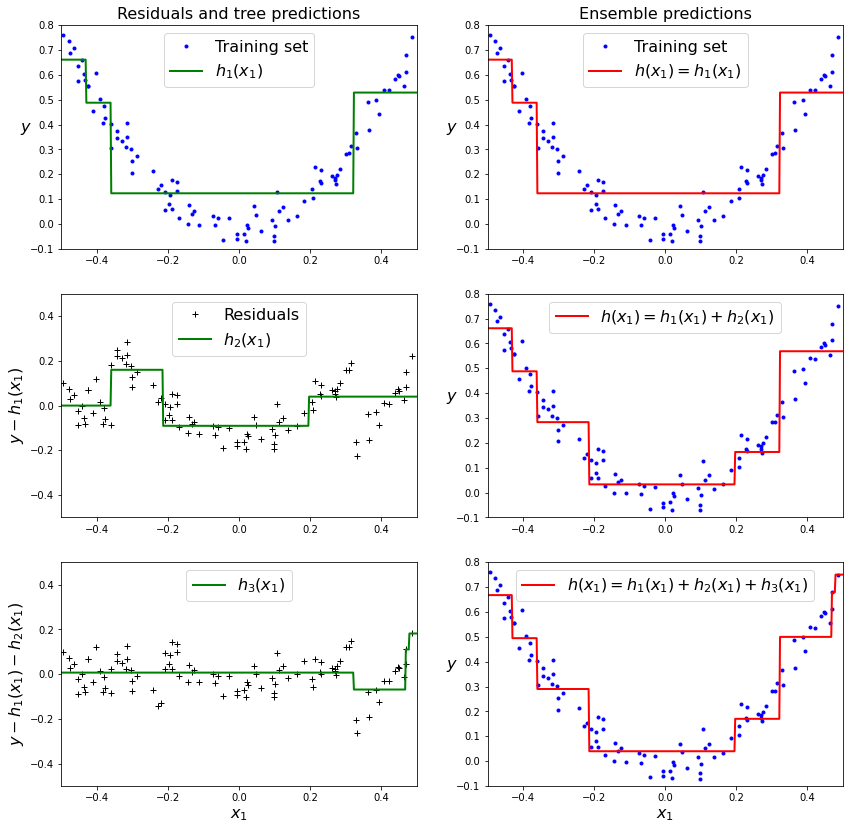

In [20]:
plt.figure(figsize=(14,14))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

#학습률 1.0
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [22]:
#학습률 0.1
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

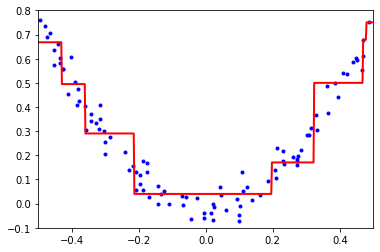

In [23]:
#트리가 충분하지 않음
plot_predictions([gbrt],X,y,axes=[-0.5, 0.5, -0.1, 0.8])

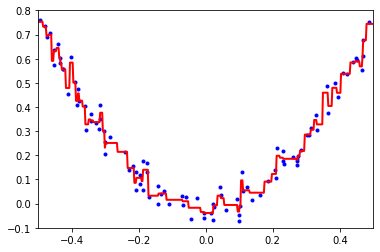

In [24]:
#과대적합
plot_predictions([gbrt_slow],X,y,axes=[-0.5, 0.5, -0.1, 0.8])

In [25]:
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)
gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=120,random_state=42)
gbrt.fit(X_train,y_train)

errors = [mean_squared_error(y_val,y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators,random_state=42)
gbrt_best.fit(X_train,y_train)


GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

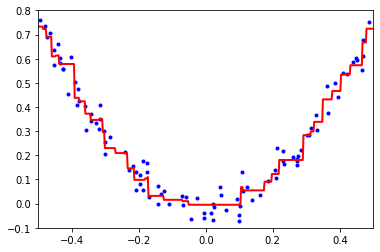

In [26]:
plot_predictions([gbrt_best],X,y,axes=[-0.5, 0.5, -0.1, 0.8])

Text(0.5, 0, '$x_1$')

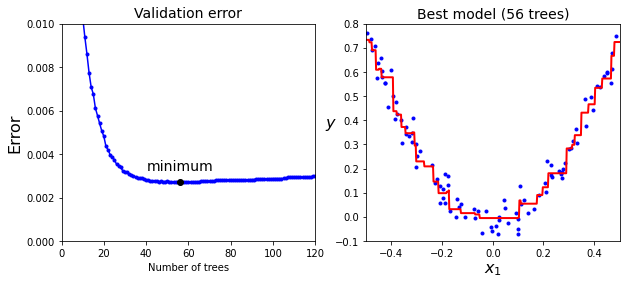

In [27]:
#조기종료

min_error = np.min(errors)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(np.arange(1,len(errors)+1),errors,"b.-")

plt.plot(bst_n_estimators,min_error,"ko")


plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)
plt.text(bst_n_estimators, min_error*1.2, "minimum", ha="center", fontsize=14)


plt.subplot(122)
plot_predictions([gbrt_best],X,y,axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

In [30]:
# 조기종료 2 (5 에포크 동안 향상되지 않을 때만 훈련 중지)
gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=120,random_state=42)
min_val_error = float("inf")
error_going_up = 0
n_epoch = 120

for n_estimators in range(1,n_epoch):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train,y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val,y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    
    else:
        error_going_up += 1
        if error_going_up == 5:
            break






In [31]:
print(gbrt.n_estimators)

61


In [32]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


In [33]:
import xgboost

xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train,y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred) 
print("Validation MSE:", val_error)           

Validation MSE: 0.004000408205406276


In [34]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)  
print("Validation MSE:", val_error)            

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
Validation MSE: 0.002630868681577655


c:\Users\outof\Anaconda3\envs\py10\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
